# Linear Regression <h3 style="color:green">Stan version</h3>

### Posterior distribution _(of regression parameters),_ and 
### Posterior predictive distribution _(of new $y$ predictions)._

_Adapted from Josep Fortiana (2023-03-13) by Jordi Abante (2024-04-15)_

# 01. Simple linear regression: A simulated example

### Generate a simulated dataset for simple linear regression

In [1]:
# More or less arbitrary parameters for the data generation
trueA<-1   
trueB<-5
trueSd<-15
sampleSize<-20 # 
n<-sampleSize 

In [2]:
# Uniformly spread x values in the interval [-n/2,n/2]
x<-(-(sampleSize-1)/2):((sampleSize-1)/2)
# y values of the form a + b*x + N(0,trueSd)
set.seed(123123)
y<-trueA+trueB*x+rnorm(n=sampleSize,mean=0,sd=trueSd)

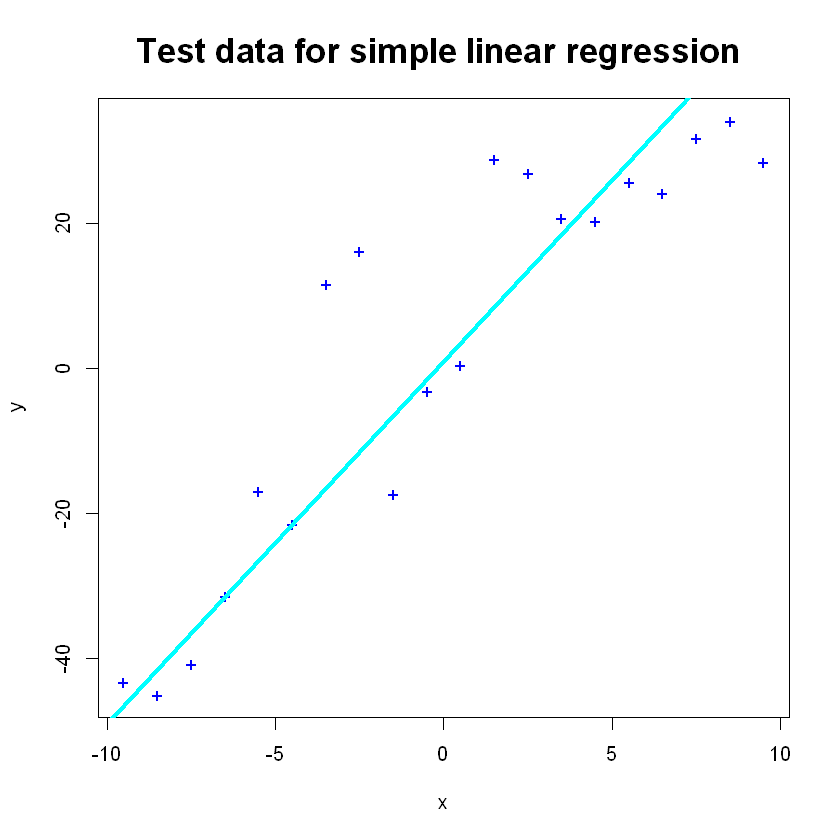

In [3]:
# Plot data points plus the line used in the generation
# Note this line is NOT a regression line, which will be computed below
# It is just an auxiliary line, used to generate the dataset
options(repr.plot.width=7, repr.plot.height=7)
plot(x,y,pch='+',cex=0.9,col="blue",main="Test data for simple linear regression ",cex.main=1.7)
abline(trueA,trueB,lwd=3.5,col="cyan")

## Fit a (classical) least squares linear regression model

In a simple LS regression model we are optimizing the square of the residuals:

$$
L(D, \boldsymbol{\beta})=\|Y-X \boldsymbol{\beta}\|^2
$$

In R, we can do this using the `lm` function:

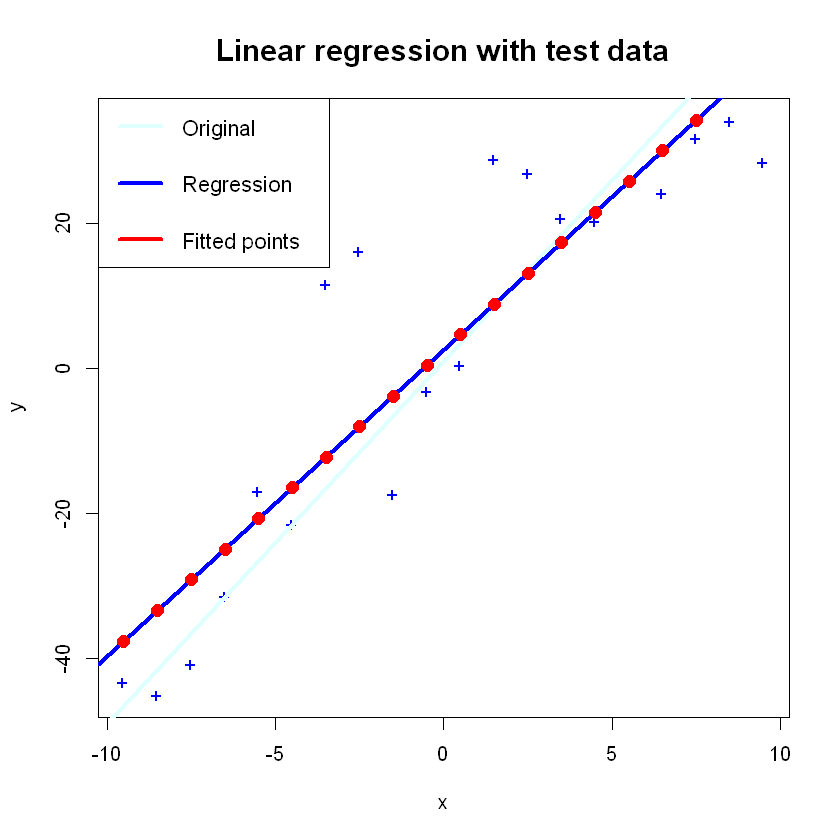

In [4]:
lm.1<-lm(y~x)
options(repr.plot.width=7, repr.plot.height=7)
plot(x,y,pch='+',cex=1.1,col="blue",main="Linear regression with test data",cex.main=1.5)
yhat<-fitted.values(lm.1)
abline(trueA,trueB,lwd=3.5,col="LightCyan")
abline(lm.1,lwd=3.5,col="blue")
points(x,yhat,pch=16,col="red",cex=1.4)
legend("topleft",c("Original    ","","Regression   ","","Fitted points"), lwd=3.5,
       col=c("LightCyan","white","blue","white","red"),cex=1.1)

### Extract information from the fitted model

In [5]:
print(lm.1)


Call:
lm(formula = y ~ x)

Coefficients:
(Intercept)            x  
      2.507        4.222  



In [6]:
S<-summary(lm.1)
S


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.140  -5.951  -3.854   3.507  24.248 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.5066     2.6939   0.930    0.364    
x             4.2224     0.4672   9.038 4.13e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.05 on 18 degrees of freedom
Multiple R-squared:  0.8194,	Adjusted R-squared:  0.8094 
F-statistic: 81.69 on 1 and 18 DF,  p-value: 4.135e-08


### Regression coefficients

In [7]:
Coeff<-coefficients(lm.1)
a.hat<-Coeff[1]
b.hat<-Coeff[2]
round(a.hat,3)
round(b.hat,3)

(Intercept) 
      2.507

x 
4.222

### Predict the response for a new $ \tilde{x}$

In [8]:
x.tilde<-c(2.5,3)  # just for example
newx<-data.frame(x=x.tilde)

In [9]:
predict(lm.1,newdata=newx)

1        2 
13.06277 15.17400

By default for linear models `type=response`

Confidence intervals for fitted values $\hat{\mu}=\hat{a}+\hat{b}\cdot\tilde{x}$.

In [10]:
predict(lm.1,newdata=newx,interval = "confidence")

,fit,lwr,upr
1,13.06277,6.894112,19.23143
2,15.17400,8.794218,21.55377


Confidence intervals for predicted values, $\hat{y}=\hat{\mu}+\varepsilon=\hat{a}+\hat{b}\cdot\tilde{x}+\varepsilon$ including the $ \textrm{N}(0,\sigma^{2})$ fluctuation around $\hat{\mu}$ (so the results are wider intervals)

In [11]:
predict(lm.1,newdata=newx,interval="prediction")

,fit,lwr,upr
1,13.06277,-12.98873,39.11427
2,15.17400,-10.92830,41.27629


# 02. Simple linear regression: Bayesian model

The purpose of fitting a model in this case is to explore the relationship between $y $ and $x $. Since both $y$ and $x$ are continuous, a simple regression line is a good start. Each observed response ($ y_{i}$) is assumed to be drawn from a normal distribution with mean ($\mu_{i}$) and standard deviation ($\sigma$). 

The expected values ($\mu_{i}$) are themselves determined by the linear predictor ($\beta_{0}+\beta\cdot x_{i}$). In this case, $\beta_{0}$ represents the $y$-intercept (value of $y$ when $x$ is equal to zero) and $\beta$ represents the rate of change in $y$ for every unit change in $x$ (the effect).

We will employ weakly informative _("non informative")_ priors. This choice is always a bit of a balancing act. If the priors are too vague (wide) the MCMC sampler can wander off into nonsense areas of likelihood rather than concentrate around areas of highest likelihood (desired when wanting the outcomes to be largely driven by the data). On the other hand, if the priors are too strong, they may have an influence on the parameters. In such a simple model, this balance is very forgiving - it is for more complex models that prior choice becomes more important.

For this simple model, we will go with Gaussian (normal) priors with relatively large standard deviations (100) for both the intercept and the treatment effect and a wide uniform for the standard deviation. The intercept $\beta_{0}$  will be centered either at $\hat{a}$ (`a.hat`), the least squares intercept or at zero, and the slope will be zero centered. Alternatively we could center $x$ and $y$ beforehand and then use a zero-centered prior for  $\beta_{0}$ too.

The model, likelihood $+ $ priors, is:

$$
\begin{array}{lcllcl}
    y_{i}     &\sim &\textrm{N}(\mu_{i},\sigma^2),\\[0.2cm]
    \mu_{i}   &=    &\beta_{0}+\beta\cdot x_{i},\\[0.2cm]
    \beta_{0} &\sim &\textrm{N}(\,\hat{a}\,,100^2), \mskip40mu\text{or }\mskip40mu\beta_{0} &\sim &\textrm{N}(\,0\,,100^2),\\[0.2cm]
    \beta     &\sim &\textrm{N}(0,100^2),\\[0.2cm]
    \sigma    &\sim &\textrm{u}(0,100).
\end{array}
$$

Alternative priors for the regression coefficients are $\textrm{Cauchy} (0,\,\cdot\,)$ distributions, as sugggested by Gelman et al (2008):

Andrew Gelman, Aleks Jakulin, Maria Grazia Pittau, Yu-Sung Su (2008), [A weakly informative default prior distribution for logistic and other regression models, Ann. Appl. Stat. 2(4): 1360-1383.](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-2/issue-4/A-weakly-informative-default-prior-distribution/10.1214/08-AOAS191.full)

There the authors suggest $\textrm{Cauchy} (0,s)$, with a scale parameter $s=2.5$.

## Stan implementation

In [1]:
#install.packages("rstan", repos= "https://cloud.r-project.org")
options(mc.cores = parallel::detectCores())
require(rstan,quietly=TRUE)
rstan_options(auto_write = TRUE)


rstan version 2.32.3 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




### Depending on your hardware

In [13]:
# Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

In [2]:
simple.regression.pred.stan.model<-"
    data{
        int<lower=1> n;
        vector[n] x; 
        vector[n] y; 
        real x_tilde; // a new x (we will compute the posterior predictive pdf at x_tilde)
        }
    parameters{
        real a;
        real b;
        real<lower=0> sigma;
        }
    model{ 
        // we need this for the likelihood
        vector[n] y_hat;
        y_hat=a+b*x; 

        // Prior 
        a~normal(0,100);        // equivalent to b0
        b~normal(0,100);        // equivalent to b1
        sigma~uniform(0,100);   // std

        // Likelihood   
        y~normal(y_hat,sigma);
        }
    generated quantities{
        real mu_tilde=a+b*x_tilde;
        real y_tilde=normal_rng(mu_tilde,sigma);
        }
"

In [3]:
# Translate model to C++ and compile to DSO:
#simple.regression.pred.stanDso <- stan_model(model_code=simple.regression.pred.stan.model) 
simple.regression.pred.stanc<- stanc(model_code=simple.regression.pred.stan.model) 

In [4]:
str(simple.regression.pred.stanc)

List of 5
 $ status       : logi TRUE
 $ model_cppname: chr "model59eaa3d3e6c0_file59eaa89077b6"
 $ cppcode      : chr "#ifndef USE_STANC3\n#define USE_STANC3\n#endif\n// Code generated by stanc v2.26.1-4-gd72b68b7-dirty\n#include "| __truncated__
 $ model_name   : chr "file59eaa89077b6"
 $ model_code   : chr "    data{\n        int<lower=1> n;\n        vector[n] x;\n        vector[n] y;\n        real x_tilde; // a new "| __truncated__
  ..- attr(*, "model_name2")= chr "file59eaa89077b6"


In [5]:
#simple.regression.pred.stanDso<-stan_model(stanc_ret = simple.regression.pred.stanc, verbose=TRUE)
simple.regression.pred.stanDso<-stan_model(stanc_ret = simple.regression.pred.stanc, verbose=FALSE)

In [6]:
# Choose a new x within the interval of x values
x_tilde<-1

In [ ]:
simple.regression.pred.stan.dat<-list(y = y, x = x, n = sampleSize, x_tilde=x_tilde)

In [20]:
# Generate posterior sample:
simple.regression.pred.stan.m1<-sampling(object=simple.regression.pred.stanDso,data=simple.regression.pred.stan.dat,chains=3,iter=10000,warmup=1500,thin=5)

In [21]:
print(simple.regression.pred.stan.m1)

Inference for Stan model: file6bf03a3d228.
3 chains, each with iter=10000; warmup=1500; thin=5; 
post-warmup draws per chain=1700, total post-warmup draws=5100.

           mean se_mean    sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
a          2.48    0.04  2.92  -3.15   0.55   2.44   4.39   8.24  5134    1
b          4.23    0.01  0.51   3.19   3.89   4.23   4.56   5.24  4634    1
sigma     12.99    0.03  2.40   9.34  11.29  12.64  14.34  18.63  5226    1
mu_tilde   6.71    0.04  2.97   0.87   4.72   6.67   8.70  12.59  5126    1
y_tilde    6.55    0.19 13.64 -20.82  -2.40   6.70  15.40  32.91  5001    1
lp__     -57.90    0.02  1.31 -61.36 -58.51 -57.56 -56.94 -56.39  5120    1

Samples were drawn using NUTS(diag_e) at Sun Apr 16 09:15:28 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [22]:
summary(simple.regression.pred.stan.m1)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
a,2.477383,0.040743695,2.9194094,-3.1541377,0.5542707,2.438357,4.387275,8.23729,5134.158,1.0003998
b,4.228928,0.007529636,0.5125866,3.1948954,3.8882494,4.232484,4.563733,5.23795,4634.325,0.9999481
sigma,12.993250,0.033160644,2.3971871,9.3391694,11.2908088,12.637239,14.336307,18.63235,5225.862,1.0005051
mu_tilde,6.706311,0.041432760,2.9663447,0.8656065,4.7173178,6.672320,8.699299,12.58746,5125.727,1.0002795
y_tilde,6.552734,0.192902751,13.6419813,-20.8164765,-2.4045689,6.700132,15.404458,32.90746,5001.244,0.9998614
lp__,-57.904882,0.018368550,1.3143181,-61.3609343,-58.5078226,-57.561450,-56.939487,-56.39245,5119.779,0.9996954


#### Compare to the least squares solution

In [23]:
coefficients(S)
sigma(lm.1)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),2.506649,2.6938789,0.9304981,3.644257e-01
x,4.222449,0.4671779,9.0382039,4.134917e-08


[1] 12.04739

These values should be compared to the MAP estimators obtained from the Bayesian samples.

## Prediction for new observations in the classical framework: Confidence interval

#### Prediction for $ x=\widetilde{x}$

In [24]:
mu.tilde<-as.numeric(a.hat+b.hat*x_tilde)
round(mu.tilde,5)

[1] 6.7291

From the (clasical-frequentist) perspective, the predicted $ \tilde{y}$ corresponding to a new $\widetilde{x}$ is given as:

$$
    \widetilde{y}=\tilde{\mu}+\varepsilon,
    \mskip30mu\text{where}\mskip20mu \tilde{\mu}=\hat{a}+\hat{b}\cdot \widetilde{x},
    \mskip30mu \varepsilon\sim\textrm{N}(0,\sigma),
    \mskip30mu\text{and}\mskip20mu \tilde{\mu},\varepsilon 
    \mskip20mu\text{are independent.}
$$

We can compute the variance of $ \tilde{\mu}$ from the covariance matrix $V=\textrm{Var}(\hat{\beta})$ of the regression coefficients vector $\hat{\beta}=(\hat{a},\hat{b})'$.

$$
    \tilde{\mu}=\hat{a}+\hat{b}\cdot\widetilde{x}= (1,\widetilde{x})\cdot\hat{\beta}.
    \mskip20mu\text{hence}\mskip10mu \textrm{Var}(\tilde{\mu}) =
    (1,\widetilde{x})\cdot V \cdot(1,\widetilde{x})'
$$

which follows from the generalization of $\textrm{Var}(aX)=a^2 \textrm{Var}(X)$.

In [25]:
y.tilde.class<-mu.tilde
round(y.tilde.class,5)

[1] 6.7291

We can get the variance of the parameter estimate using `vcov`:

In [26]:
V<-vcov(lm.1)
round(V,5)

,(Intercept),x
(Intercept),7.25698,0.00000
x,0.00000,0.21826


In [27]:
var.mu_tilde<-as.numeric(t(c(1,x_tilde)) %*% V %*% c(1,x_tilde))
round(var.mu_tilde,4)
sigma.mu_tilde=sqrt(var.mu_tilde)
round(sigma.mu_tilde,4)

[1] 7.4752

[1] 2.7341

Finally, $ \tilde{y}$ follows a normal distribution centered on $\tilde{\mu}$ and variance:

$$
    \textrm{Var}(\widetilde{y})=\textrm{Var}(\tilde{\mu})+\textrm{Var}(\varepsilon) = \textrm{Var}(\tilde{\mu})+\sigma^2.
$$

In [28]:
var.y_tilde<-var.mu_tilde+sigma(lm.1)^2
round(var.y_tilde,4)
sigma.y_tilde=sqrt(var.y_tilde)
round(sigma.y_tilde,4)

[1] 152.6149

[1] 12.3537

With this information we can compute confidence intervals for predicted values.

## Diagnostic plots

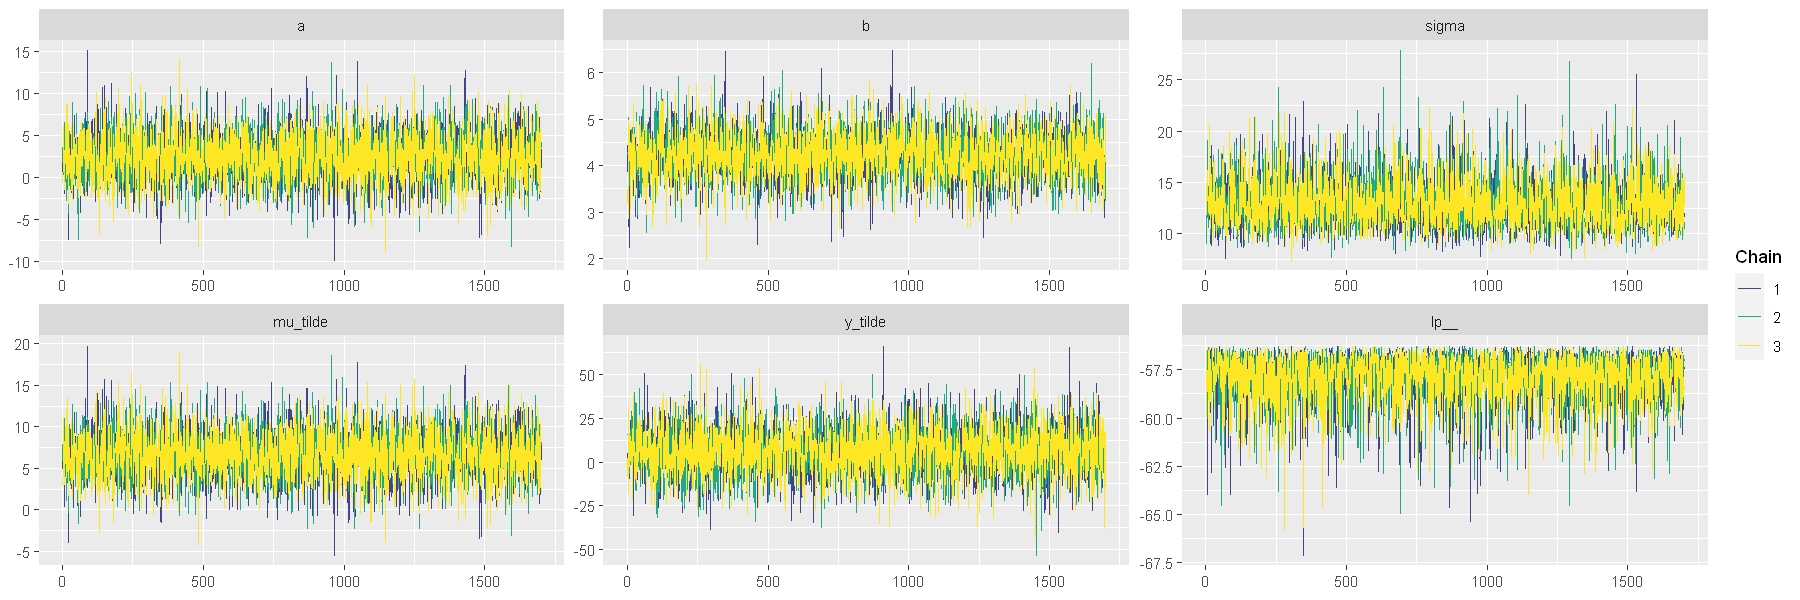

In [30]:
color_scheme_set("viridis")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_trace(simple.regression.pred.stan.m1)

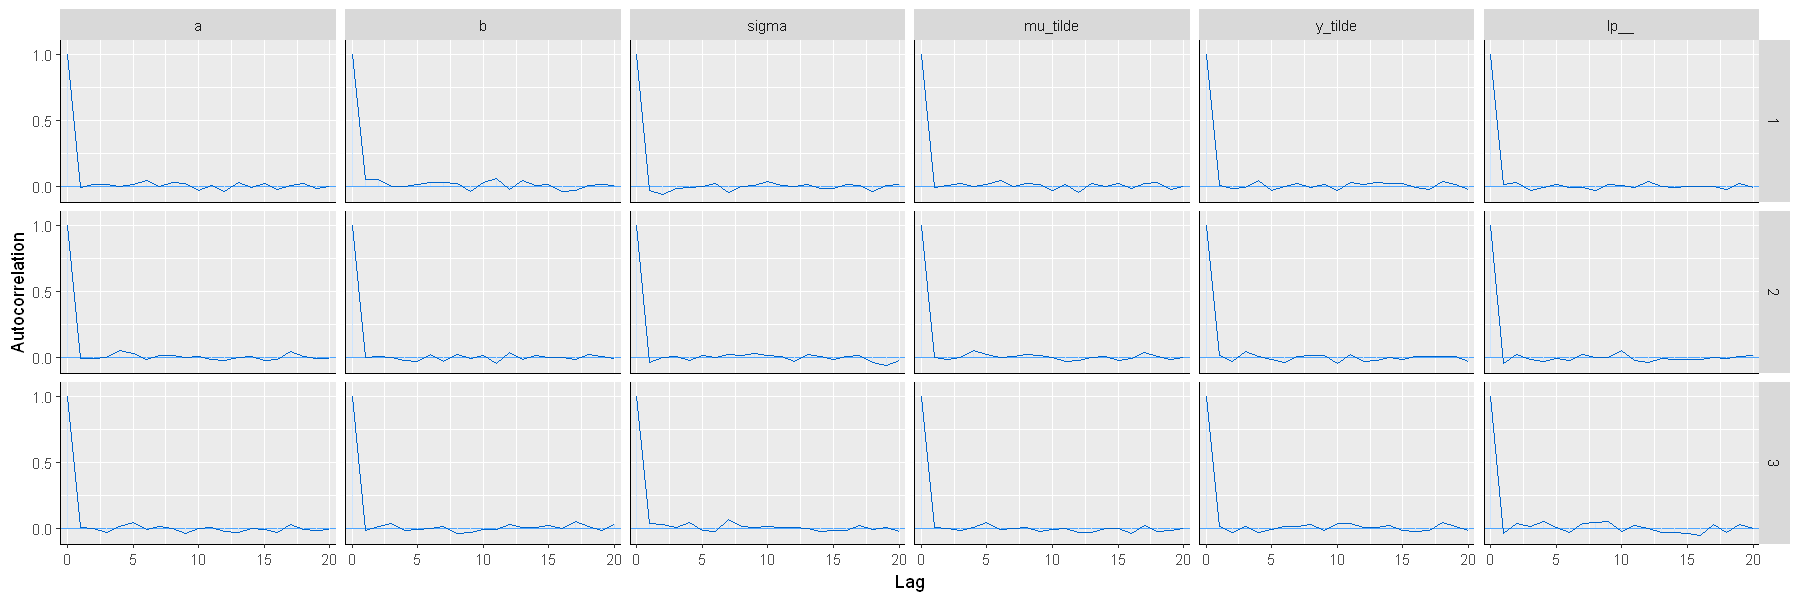

In [31]:
color_scheme_set("brightblue")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_acf(simple.regression.pred.stan.m1)

## Summary plots

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


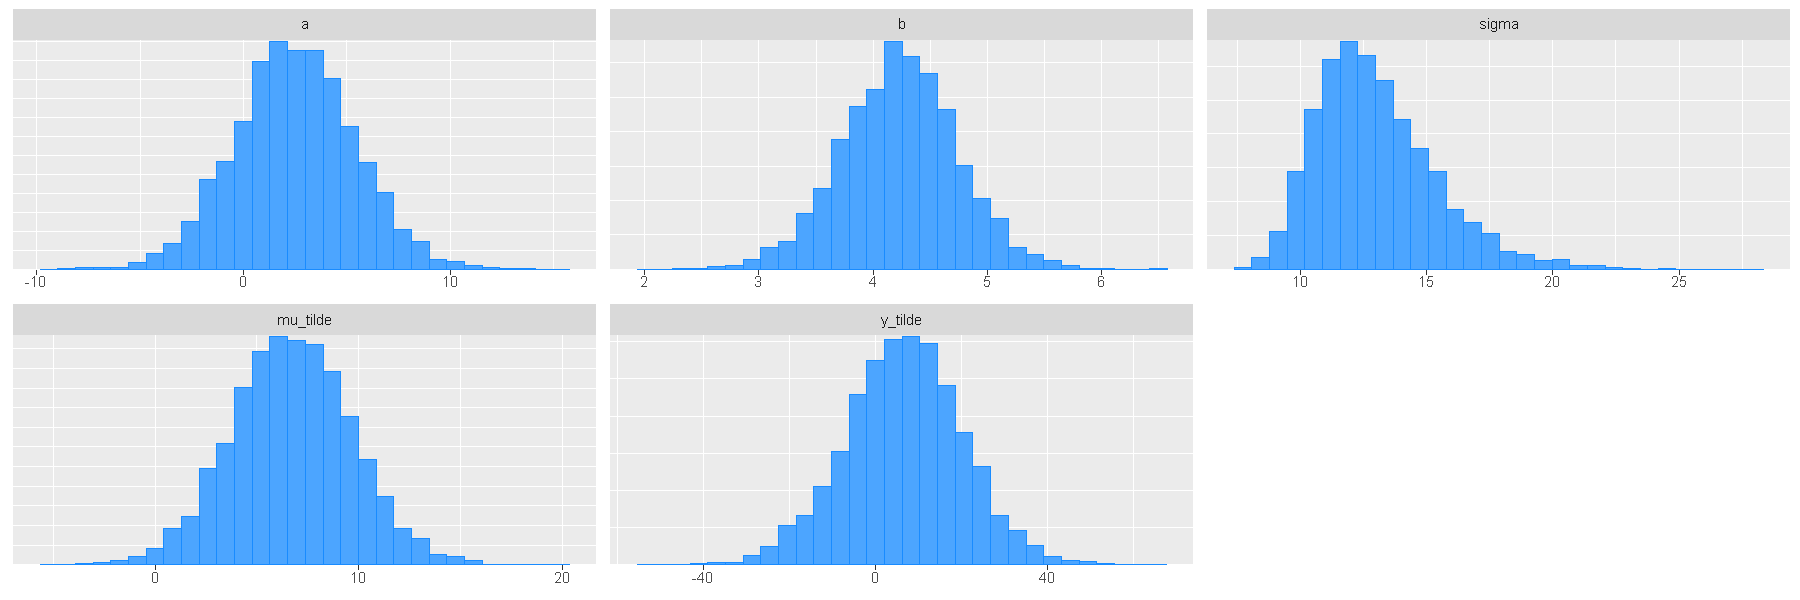

In [32]:
color_scheme_set("brightblue")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_hist(simple.regression.pred.stan.m1,pars=c("a","b","sigma","mu_tilde","y_tilde"))

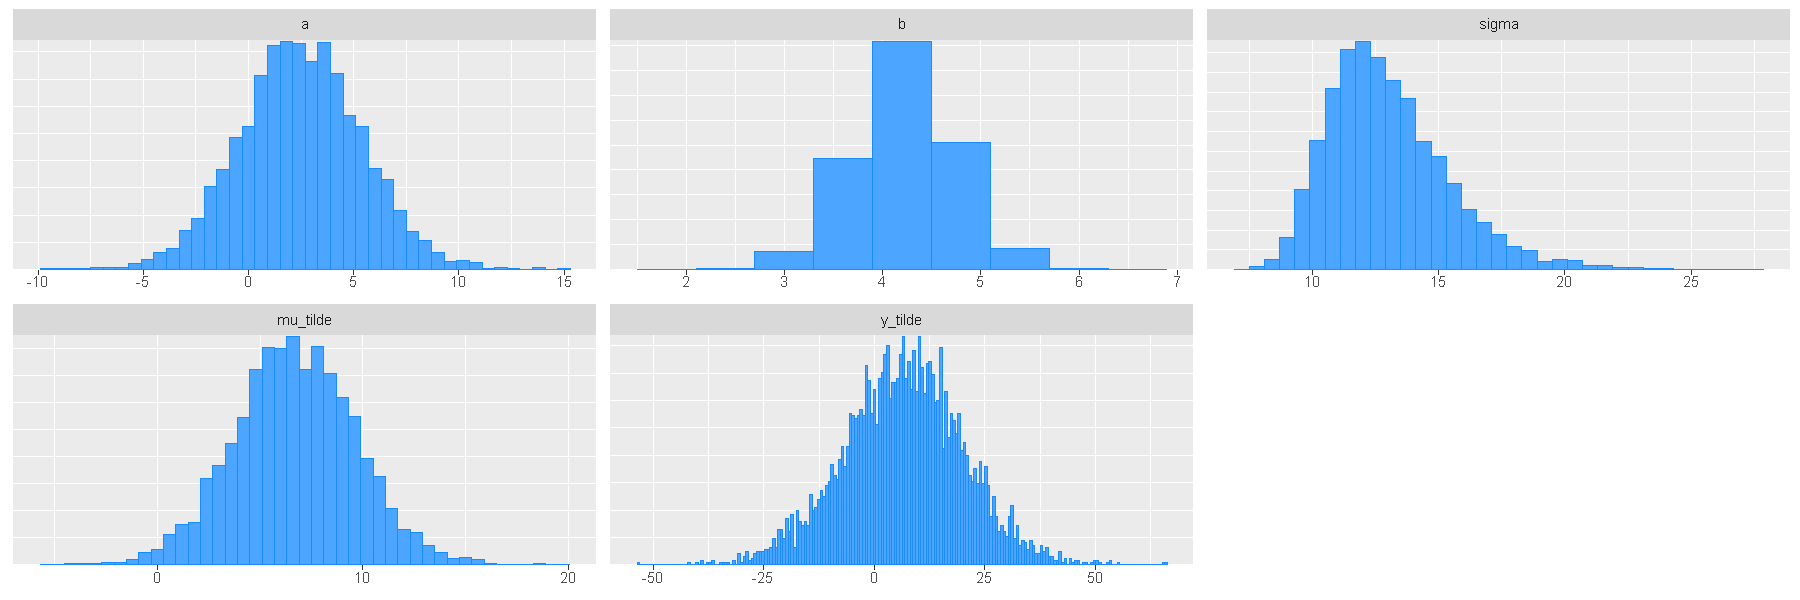

In [33]:
color_scheme_set("brightblue")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_hist(simple.regression.pred.stan.m1,pars=c("a","b","sigma","mu_tilde","y_tilde"),binwidth=0.6)

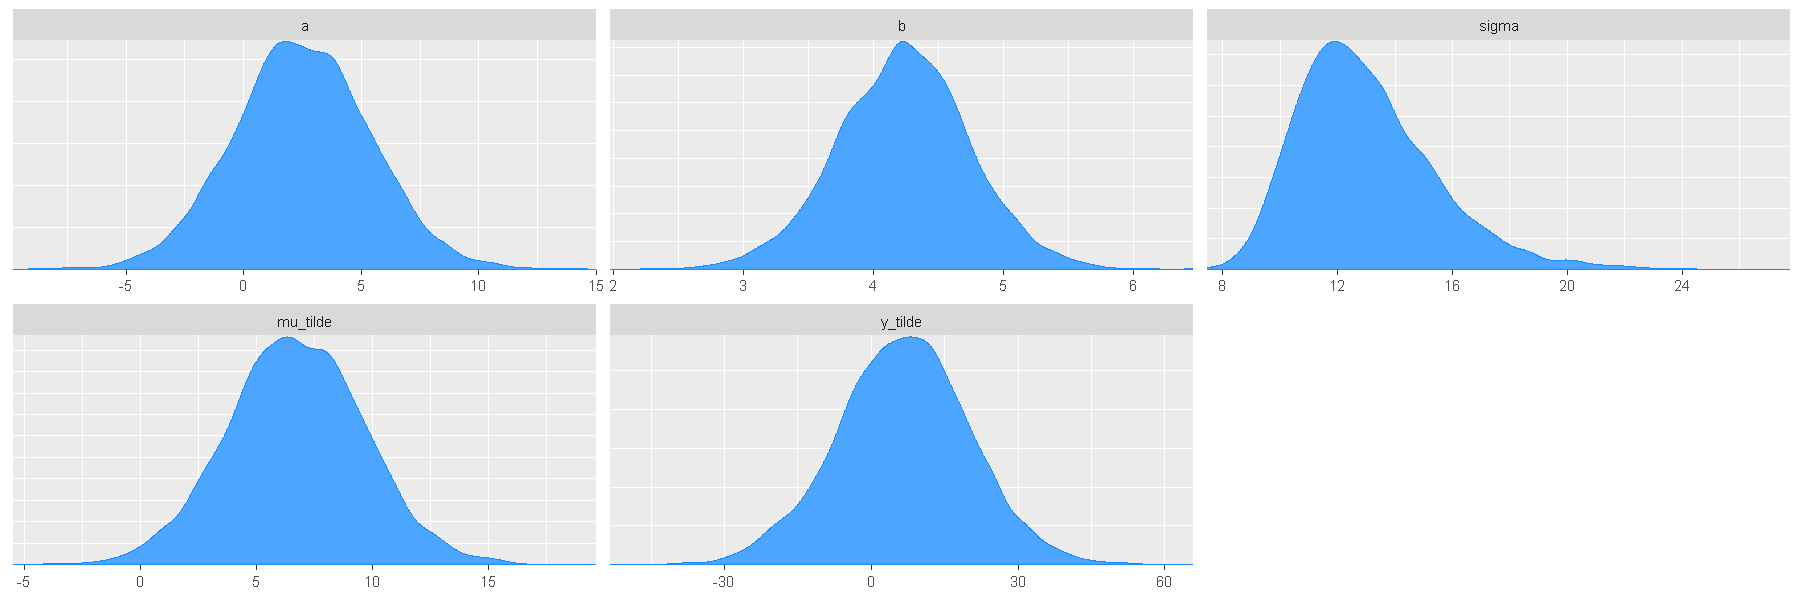

In [34]:
color_scheme_set("brightblue")
options(repr.plot.width=15, repr.plot.height=5)
mcmc_dens(simple.regression.pred.stan.m1,pars=c("a","b","sigma","mu_tilde","y_tilde"))

We can plot central (quantile-based) posterior interval estimates from MCMC draws:

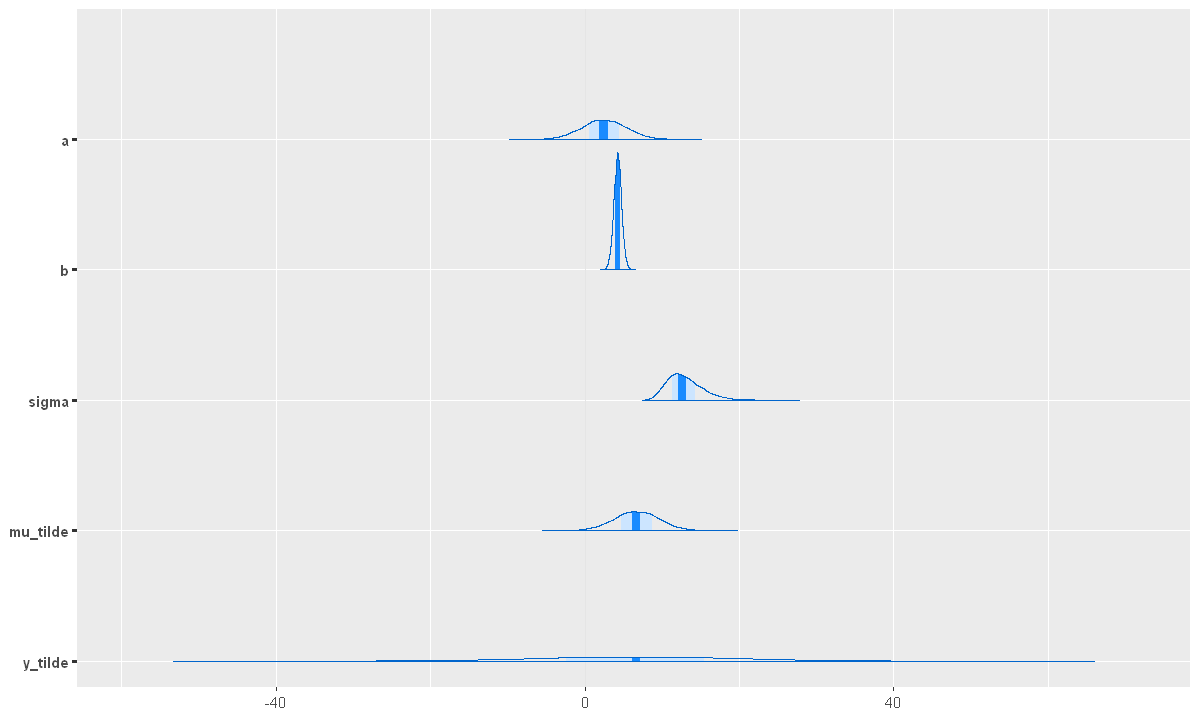

In [35]:
color_scheme_set("brightblue")
options(repr.plot.width=10, repr.plot.height=6)
mcmc_areas(simple.regression.pred.stan.m1,pars=c("a","b","sigma","mu_tilde","y_tilde"))

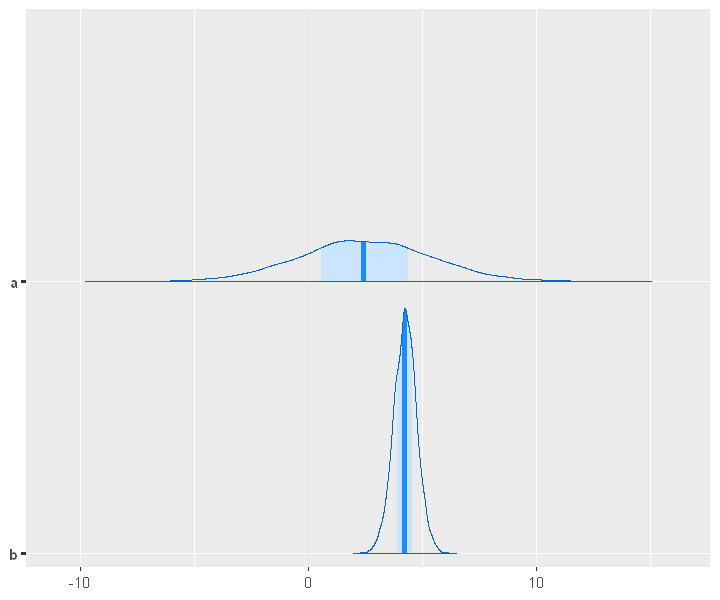

In [36]:
color_scheme_set("brightblue")
options(repr.plot.width=6, repr.plot.height=5)
mcmc_areas(simple.regression.pred.stan.m1,pars=c("a","b"))

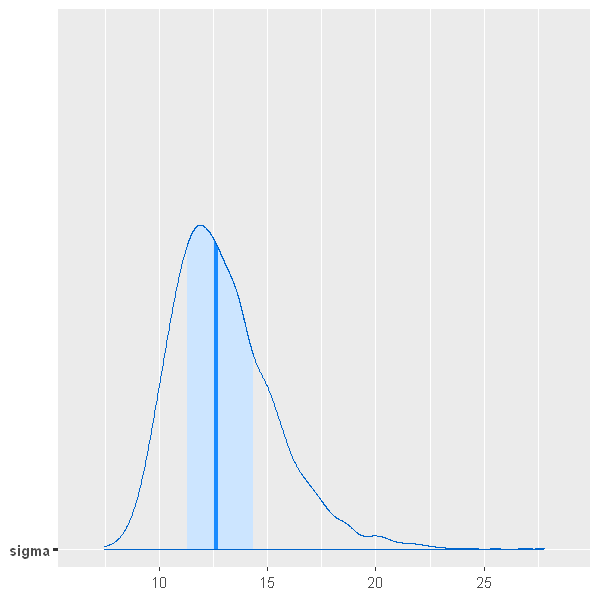

In [37]:
color_scheme_set("brightblue")
options(repr.plot.width=5, repr.plot.height=5)
mcmc_areas(simple.regression.pred.stan.m1,pars=c("sigma"))

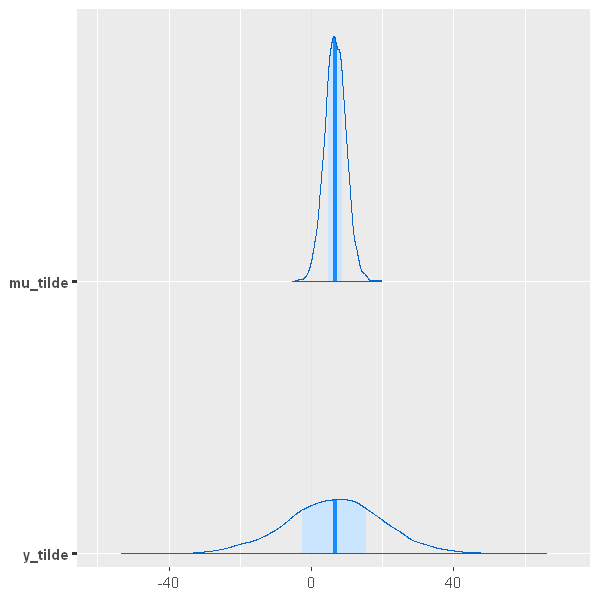

In [38]:
color_scheme_set("brightblue")
options(repr.plot.width=5, repr.plot.height=5)
mcmc_areas(simple.regression.pred.stan.m1,pars=c("mu_tilde","y_tilde"))

# 03. The `Advertising` dataset

From [An Introduction to Statistical Learning with Applications in R (ISLR)](https://www.statlearning.com/). 

File [`Advertising.csv`](https://www.statlearning.com/s/Advertising.csv) from the textbook web page. 

In this section we follow the treatment of the `Advertising` dataset from chapters 2 and 3.

Suppose that we are statistical consultants hired by a client to investigate  the  association  between 
advertising  and  sales  of  a  particular product.  The  `Advertising`  data  set  consists  of  the  
sales  of  that  product in 200 different markets, along with advertising budgets for the product in each 
of those markets for three different media: TV, radio, and newspaper.  It  is  not  possible  for  our  
client  to directly increase sales of the product. On the other hand, they can control the advertising
expenditure  in  each  of  the  three  media.  Therefore,  if  we determine that there 
is an association between advertising and sales, then we can instruct our client to adjust 
advertising budgets, thereby indirectly increasing sales.

In other words, our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.
In this setting, the advertising budgets are  input  variables  while sales is an output  variable. 
The input variables are typically denoted using the symbol $ X$, with a subscript to distinguish them. So $ X_{1}$ might be the TV budget, 
$X_{2}$ the radio  budget, and $X_{3}$ the newspaper  budget. The inputs go by different names, such as _predictors,_
_independent variables,_ _features,_ or sometimes just _variables._ The output variable —in this case, sales— is often 
called the _response_  or _dependent  variable,_ and is typically denoted using the symbol $Y$.

### Read dataset.

Omit first column, the index of each sample. If needed it could be recovered by: `row.names(Advertising)`.

In [39]:
Advertising<-read.csv("Data/Advertising.csv")
#Advertising<-read.csv("https://www.statlearning.com/s/Advertising.csv")
Advertising<-Advertising[,-1]

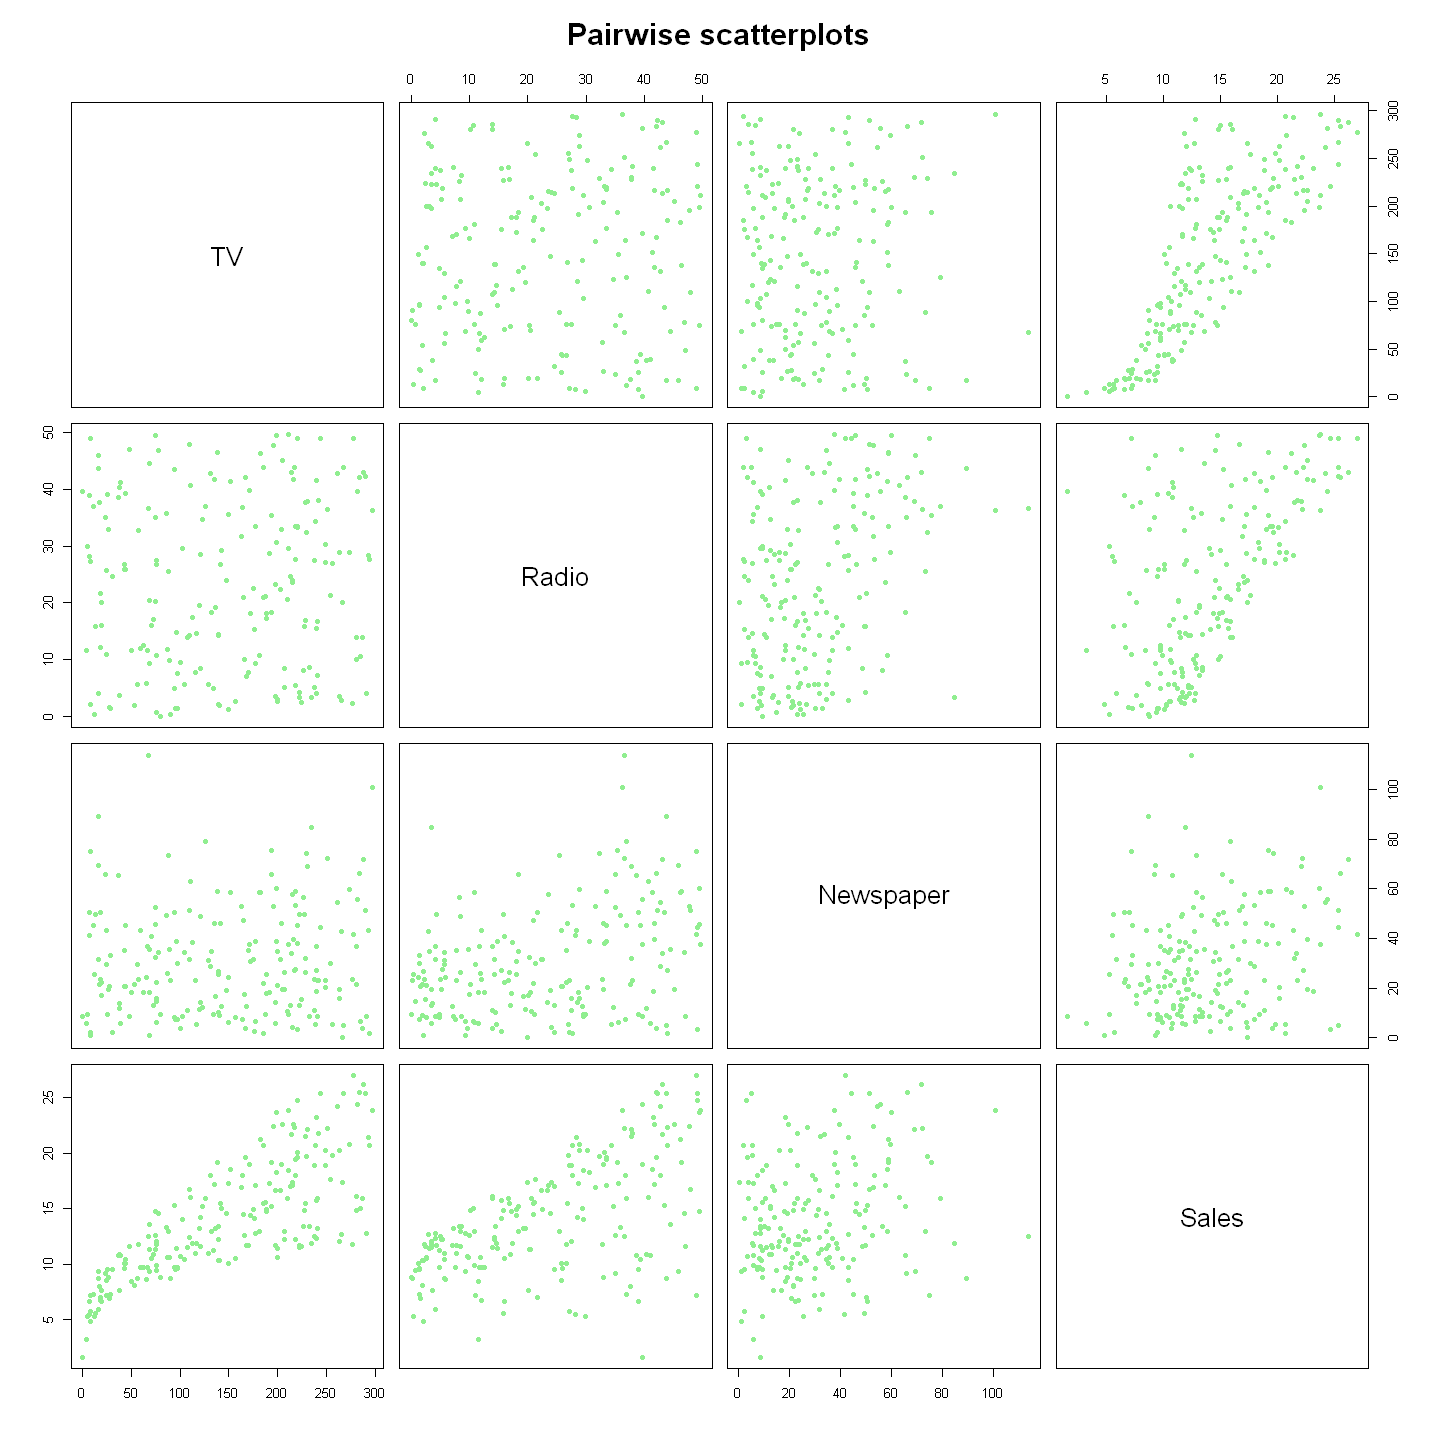

In [40]:
options(repr.plot.width=12, repr.plot.height=12)
plot(Advertising,pch=19,col="LightGreen",cex=0.8,main="Pairwise scatterplots",cex.main=1.5)

In [41]:
#cor(Advertising)
#round(cor(Advertising),2)
round(cor(Advertising),1)

,TV,Radio,Newspaper,Sales
TV,1.0,0.1,0.1,0.8
Radio,0.1,1.0,0.4,0.6
Newspaper,0.1,0.4,1.0,0.2
Sales,0.8,0.6,0.2,1.0


## Multiple regression (classical)

Multiple linear regression of Sales on all three predictors

In [42]:
lm.Advertising.01<-lm(Sales~TV+Radio+Newspaper,data=Advertising)
# Equivalent, alternative notation
#lm.Advertising.01<-lm(Sales~.,data=Advertising)
S<-summary(lm.Advertising.01)
S


Call:
lm(formula = Sales ~ TV + Radio + Newspaper, data = Advertising)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8277 -0.8908  0.2418  1.1893  2.8292 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.938889   0.311908   9.422   <2e-16 ***
TV           0.045765   0.001395  32.809   <2e-16 ***
Radio        0.188530   0.008611  21.893   <2e-16 ***
Newspaper   -0.001037   0.005871  -0.177     0.86    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.686 on 196 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8956 
F-statistic: 570.3 on 3 and 196 DF,  p-value: < 2.2e-16


In [43]:
A<-anova(lm.Advertising.01)
A

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
TV,1,3.314618e+03,3.314618e+03,1.166731e+03,1.809337e-84
Radio,1,1.545617e+03,1.545617e+03,5.440501e+02,1.882722e-58
Newspaper,1,8.871717e-02,8.871717e-02,3.122805e-02,8.599151e-01
Residuals,196,5.568253e+02,2.840945e+00,NA,NA


Rename response and model for the sake of pithy expressions

In [44]:
y<-Advertising$Sales
n<-length(y)
n
# (number of predictors)
p<-3 
# (number of columns in the regression matrix, including the colummn of ones for the intercept)
m<-p+1
p
n

[1] 200

[1] 3

[1] 200

In [45]:
lm.1<-lm.Advertising.01

In [46]:
# Keep the classical intercept (eventually to center the Bayesian prior for the intercept parameter)
beta<-as.numeric(coef(lm.1))
beta0.hat<-beta[1]
round(beta0.hat,4)

[1] 2.9389

In [47]:
X<-model.matrix(lm.1)
attr(X,"assign")<-NULL
# Remove the "intercept" column of ones 
X<-X[, -1]
#str(X)
head(X)

,TV,Radio,Newspaper
1,230.1,37.8,69.2
2,44.5,39.3,45.1
3,17.2,45.9,69.3
4,151.5,41.3,58.5
5,180.8,10.8,58.4
6,8.7,48.9,75.0


## 04. Bayesian linear regression

## Model

### Likelihood

Each of the $ n$ observed responses $y_{i}$ ($1\leq i\leq n$) is assumed to be drawn from a normal distribution with mean $\mu_{i}$ and standard deviation $\sigma$ (or precision $\tau=1/\sigma^{2}$).

The expected values ($\mu_{i}$) are themselves determined by the linear predictor ($\beta_{0}+x_{i}\cdot\beta$), $x_{i}\in\mathbb{R}^p$. 

$\beta_{0}$ is the $y$-intercept and each $\beta_{j}\in\R$, $j\geq 1$ represents the rate of change in $y$ for every unit change in the $j$-th effect $x_{j}$ ($1\leq j\leq p$).

### Priors

Gaussian (normal) priors with relatively large standard deviations for the regression coefficients, intercept centered on the classical estimate and the others on zero,
and a uniform for the standard deviation. 

In JAGS the normal distribution is parameterized with mean and precision $ \tau=1/\sigma^{2}$, hence a noninformative normal prior will have a _small_ precision. In Stan the normal distribution is parameterized with $\sigma$, as in R.
  
$$
\begin{array}{lcl}
        y_{i}         &\sim &\textrm{N}(\mu_{i},\sigma),\\[0.2cm]
        \mu_{i}       &=    &\beta_{0}+x_{i}\cdot\beta,\mskip20mu 1\leq i\leq n.\\[0.2cm]
         y            &\sim &\textrm{N}(\mu,\sigma), \mskip20mu\text{(vector notation)}\\[0.2cm]  
        \mu           &=    &\beta_{0}+X\cdot\beta, \mskip20mu\text{(matrix notation)}\\[0.2cm]
        \beta_{0}     &\sim &\textrm{Cauchy}(0,10),\\[0.2cm]
        \beta_{j}     &\sim &\textrm{Cauchy}(0,2.5),\mskip20mu 1\leq j\leq p.\\[0.2cm]
        \sigma        &\sim &\textrm{u}(0,100).
\end{array}
$$

Alternative priors for the regression coefficients are $ \textrm{Cauchy} (0,\,\cdot\,)$ distributions, as sugggested by Gelman et al (2008).

Andrew Gelman, Aleks Jakulin, Maria Grazia Pittau, Yu-Sung Su (2008), [A weakly informative default prior distribution for logistic and other regression models, Ann. Appl. Stat. 2(4): 1360-1383.](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-2/issue-4/A-weakly-informative-default-prior-distribution/10.1214/08-AOAS191.full)

There the authors suggest $\textrm{Cauchy} (0,s)$, with a scale parameter $s=2.5$.

## Stan implementation

In [48]:
#install.packages("rstan", repos= "https://cloud.r-project.org")
options(mc.cores = parallel::detectCores())
require(rstan)
rstan_options(auto_write = TRUE)

### Depending on your hardware

In [49]:
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')

In [50]:
Advertising.stan.model<-"
    data{
    int<lower=1>  n;
    int<lower=1>  p;
    matrix[n,p]   X; 
    vector[n]     y; 
    row_vector[p] x_tilde; // a new x (we will compute the posterior predictive pdf at x_tilde)
    }
    parameters{
    real a;
    vector[p] b;
    real<lower=0> sigma;
    }
    model{ 
        vector[n] y_hat;
        y_hat=a+X*b; 

        // Prior 
        a ~ cauchy(0,10);        //prior following Gelman 2008

        for(i in 1:p)
            b[i] ~ cauchy(0,2.5);  
  
        sigma~uniform(0,100);

        // Likelihood   
        y~normal(y_hat,sigma);
    }
    generated quantities{
        real mu_tilde=a+x_tilde*b  ;
        real y_tilde=normal_rng(mu_tilde,sigma);
    }
"

In [51]:
# Translate model to C++ and compile to DSO:
Advertising.stanDso <- stan_model(model_code=Advertising.stan.model) 

In [52]:
x.tilde<-colMeans(X) # We predict for a new x equal to the average of the observed data
round(x.tilde,2)

TV     Radio Newspaper 
   147.04     23.26     30.55

In [53]:
Advertising.stan.dat<-list(n = n, p=p, X = X, y = y,x_tilde=x.tilde)

In [54]:
# Generate posterior sample:
Advertising.stan.m1<-sampling(object=Advertising.stanDso,
                                    data=Advertising.stan.dat,chains=3,iter=6000,warmup=500,thin=1)

In [55]:
#str(Advertising.stan.m1)

In [56]:
print(Advertising.stan.m1)

Inference for Stan model: anon_model.
3 chains, each with iter=6000; warmup=500; thin=1; 
post-warmup draws per chain=5500, total post-warmup draws=16500.

            mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
a           2.93    0.00 0.31    2.32    2.72    2.93    3.14    3.54  9190
b[1]        0.05    0.00 0.00    0.04    0.04    0.05    0.05    0.05 14929
b[2]        0.19    0.00 0.01    0.17    0.18    0.19    0.19    0.21 10011
b[3]        0.00    0.00 0.01   -0.01    0.00    0.00    0.00    0.01 11286
sigma       1.70    0.00 0.09    1.53    1.63    1.69    1.75    1.88  9539
mu_tilde   14.02    0.00 0.12   13.78   13.94   14.02   14.10   14.26 16838
y_tilde    14.04    0.01 1.70   10.67   12.89   14.04   15.19   17.31 16824
lp__     -204.52    0.02 1.63 -208.50 -205.35 -204.20 -203.33 -202.37  6733
         Rhat
a           1
b[1]        1
b[2]        1
b[3]        1
sigma       1
mu_tilde    1
y_tilde     1
lp__        1

Samples were drawn using NUTS(dia

In [57]:
round(summary(Advertising.stan.m1)$summary,6)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
a,2.931244,0.003249,0.311444,2.321486,2.720348,2.930288,3.140849,3.538244,9190.295,1.000045
b[1],0.045770,0.000012,0.001422,0.042964,0.044827,0.045769,0.046726,0.048578,14928.805,0.999972
b[2],0.188628,0.000086,0.008650,0.171264,0.182944,0.188622,0.194450,0.205573,10010.825,0.999924
b[3],-0.000924,0.000055,0.005891,-0.012510,-0.004890,-0.000880,0.003116,0.010459,11285.517,0.999995
sigma,1.695990,0.000893,0.087250,1.534981,1.634552,1.693403,1.752949,1.876479,9539.278,1.000049
mu_tilde,14.021343,0.000930,0.120621,13.783641,13.940920,14.021322,14.101924,14.257913,16837.804,0.999843
y_tilde,14.036095,0.013086,1.697355,10.674621,12.890300,14.044431,15.185950,17.309323,16823.656,0.999852
lp__,-204.522822,0.019809,1.625479,-208.503676,-205.352944,-204.197017,-203.327213,-202.369406,6733.211,1.000687


#### Compare with classical solution coefficients

In [58]:
round(S$coefficients,5)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),2.93889,0.31191,9.42229,0.00000
TV,0.04576,0.00139,32.80862,0.00000
Radio,0.18853,0.00861,21.89350,0.00000
Newspaper,-0.00104,0.00587,-0.17671,0.85992


In [59]:
round(sigma(lm.1),5)

[1] 1.68551

In [60]:
round(S$r.squared,5)

[1] 0.89721

In [61]:
#A<-anova(lm.1)
A

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
TV,1,3.314618e+03,3.314618e+03,1.166731e+03,1.809337e-84
Radio,1,1.545617e+03,1.545617e+03,5.440501e+02,1.882722e-58
Newspaper,1,8.871717e-02,8.871717e-02,3.122805e-02,8.599151e-01
Residuals,196,5.568253e+02,2.840945e+00,NA,NA


In [62]:
SS<-A$Sum
round(SS,5)

[1] 3314.61817 1545.61660    0.08872  556.82526

In [63]:
#install.packages("bayesplot",dependencies=TRUE,repos= "https://cloud.r-project.org")
require(bayesplot,quietly=TRUE)

### Diagnostics: Traceplot

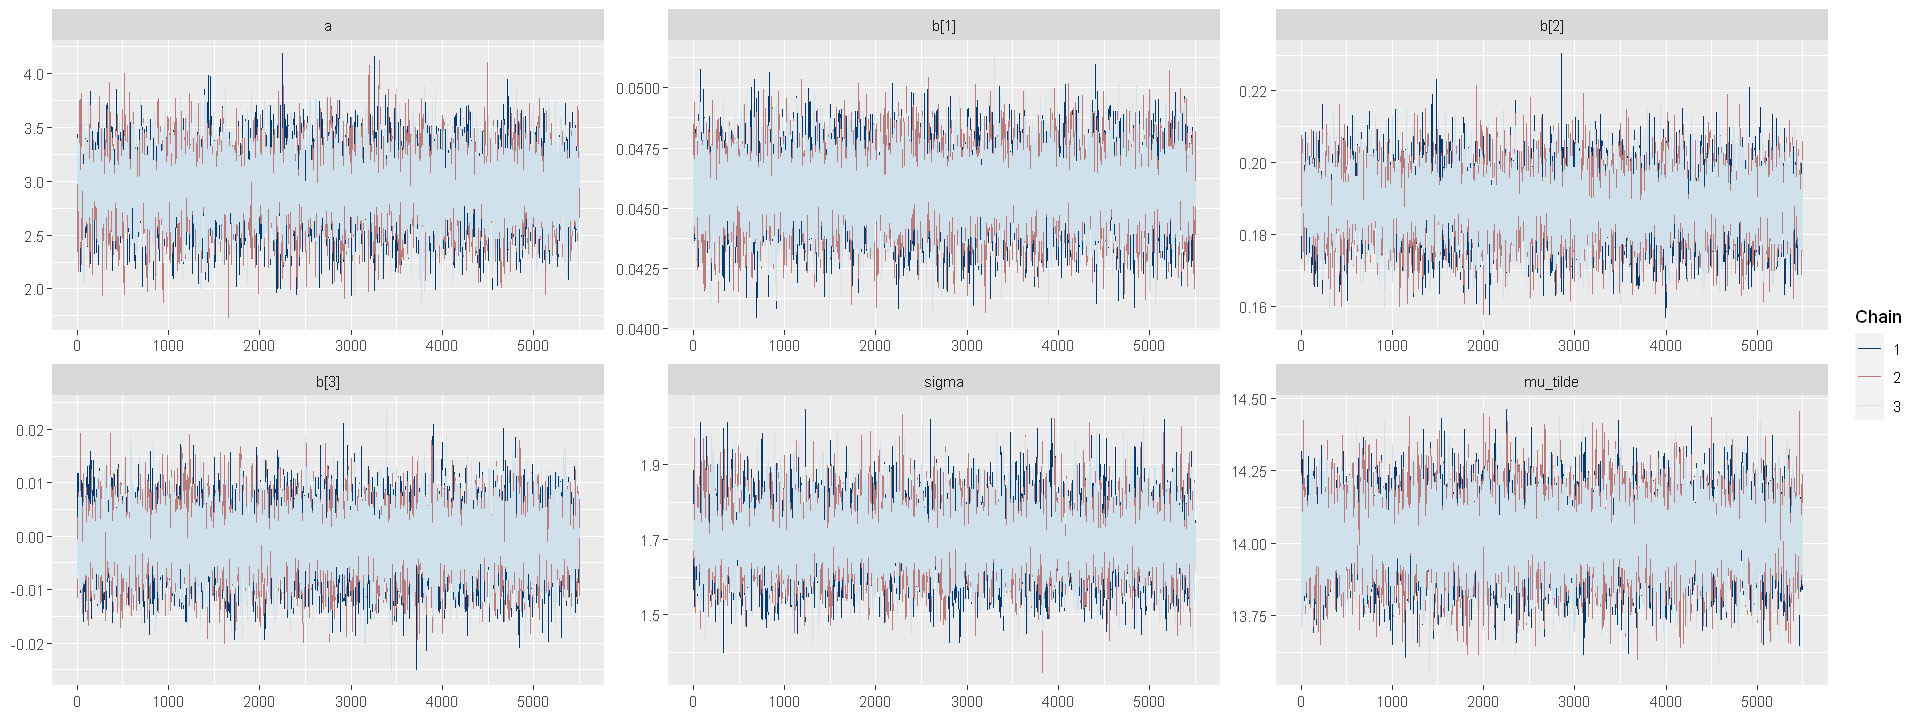

In [64]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_trace(Advertising.stan.m1, pars = c("a","b[1]","b[2]","b[3]","sigma","mu_tilde"))

A syntax to list all `b` parameters

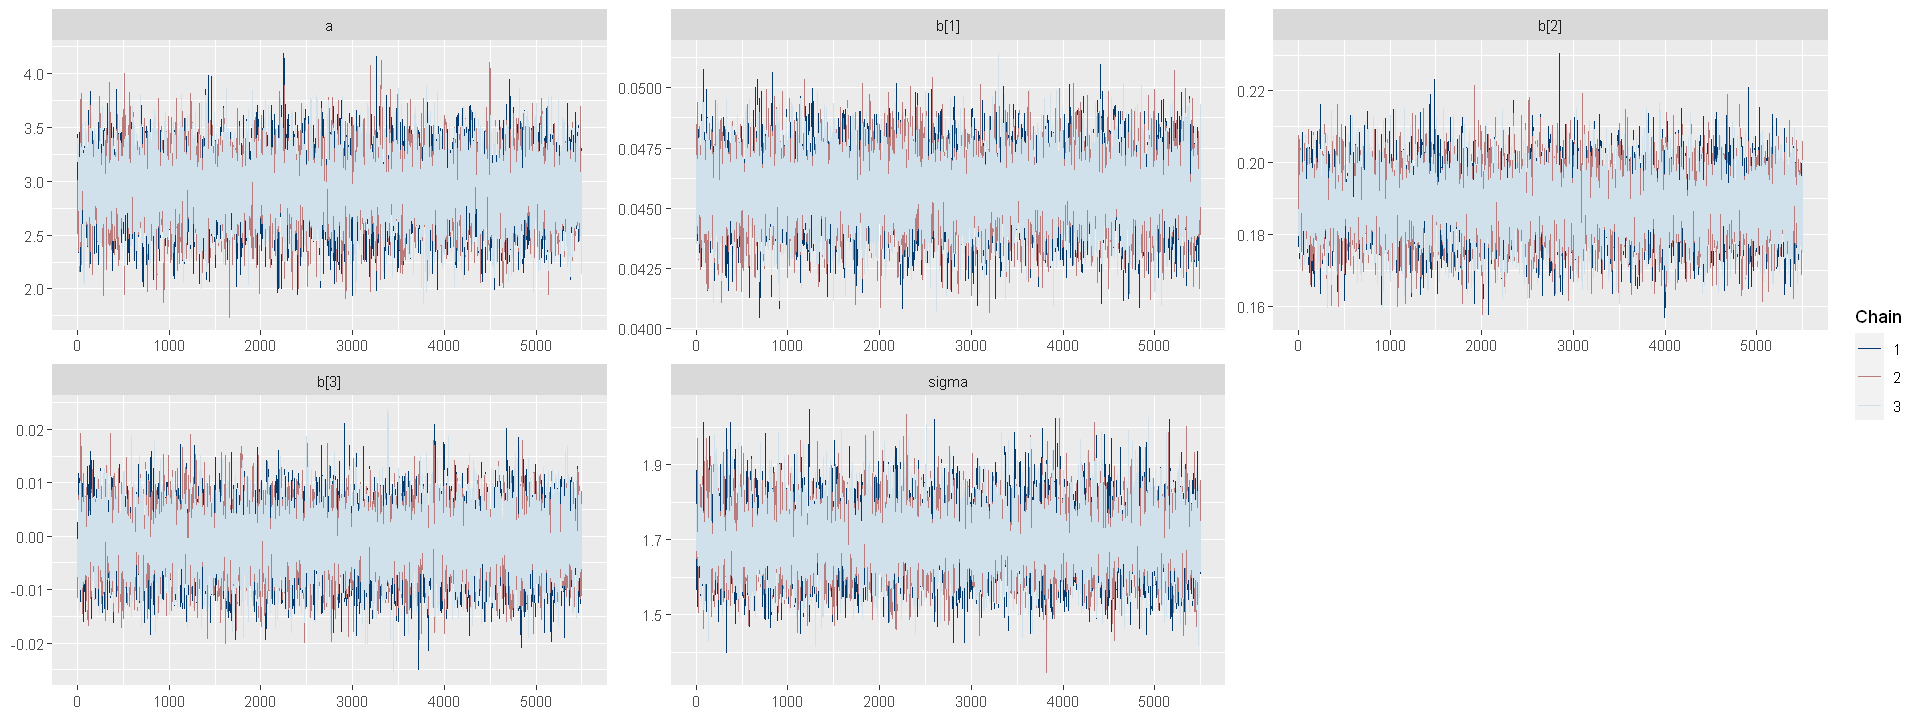

In [65]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_trace(Advertising.stan.m1, pars = c(vars("a",starts_with("b"),"sigma")))

### Diagnostics: Autocorrelation plot

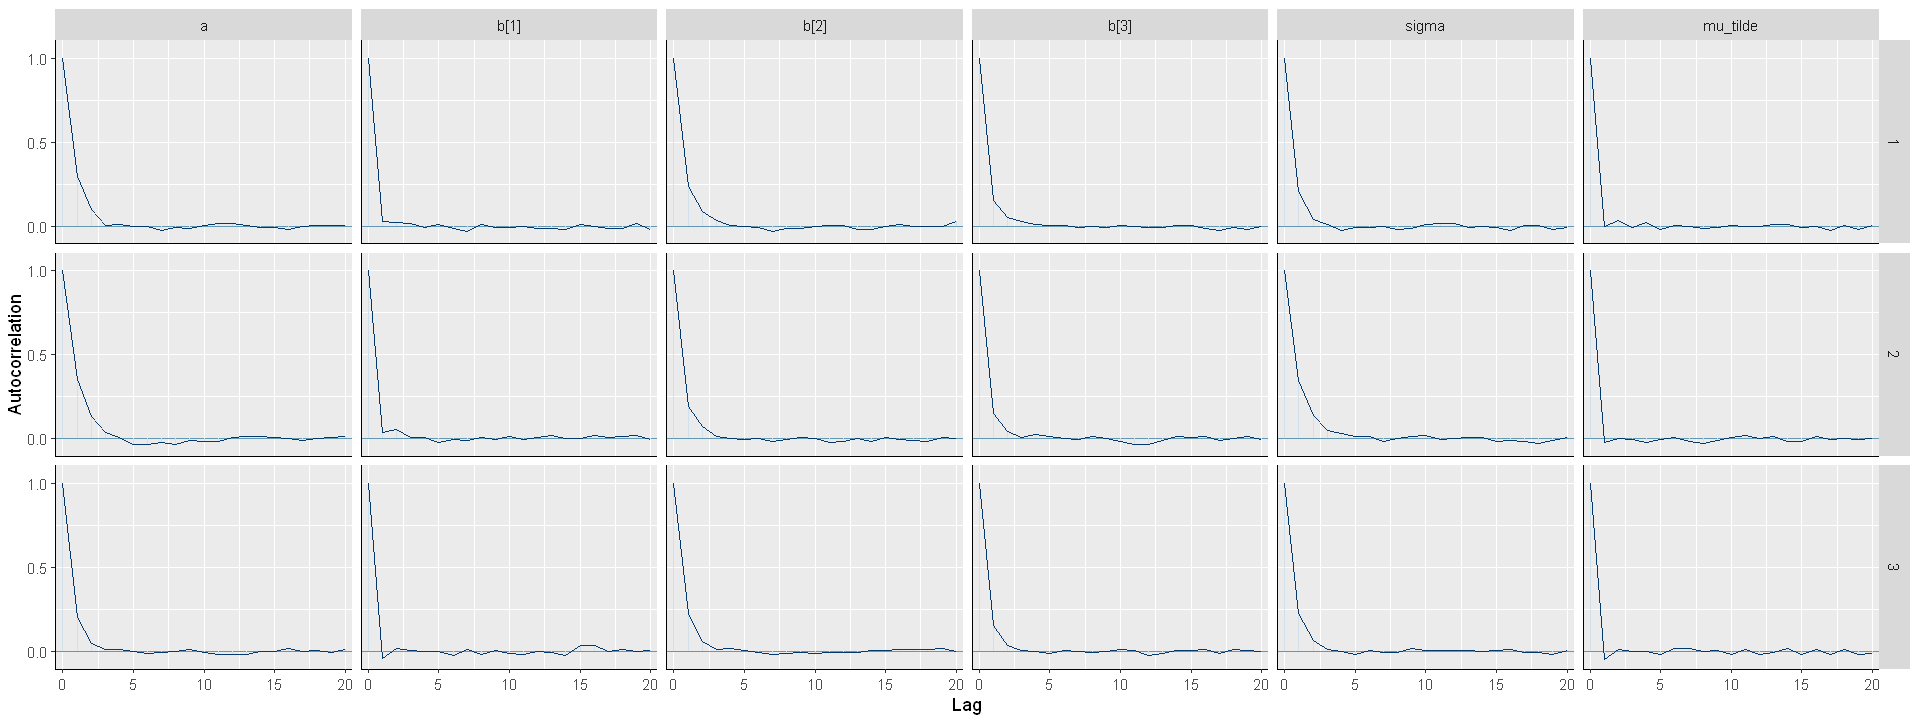

In [66]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("blue")
mcmc_acf(Advertising.stan.m1, pars = c(vars("a",starts_with("b"),"sigma","mu_tilde")))

###  Posterior area plots (posterior density + posterior credible intervals)

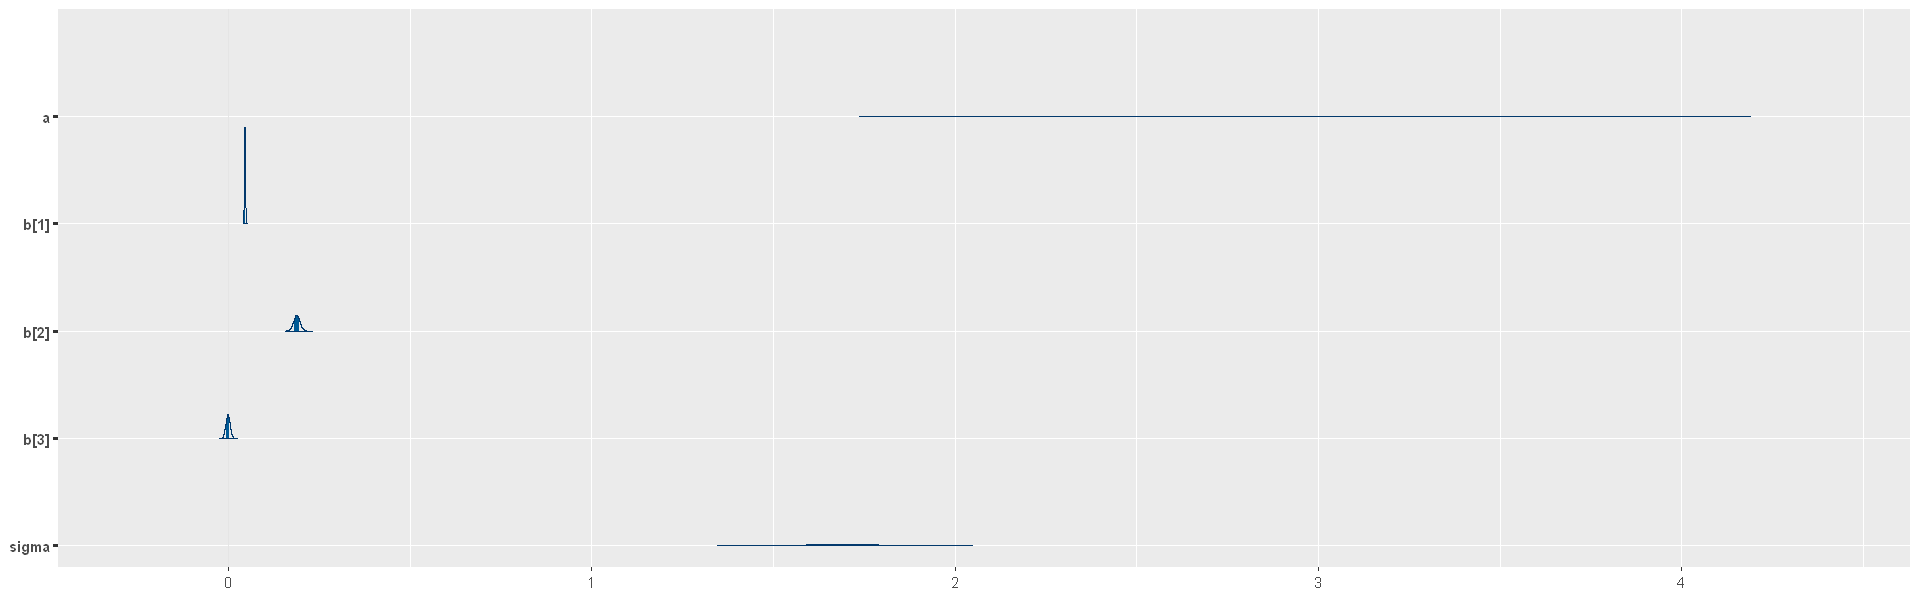

In [67]:
options(repr.plot.width=16, repr.plot.height=5)
color_scheme_set("mix-blue-red")
mcmc_areas(Advertising.stan.m1, pars = c(vars("a",starts_with("b"),"sigma")))

Problem with plotting parameters together is, either range or dispersion can be quite different.

Then one can plot them separately to better visualize.

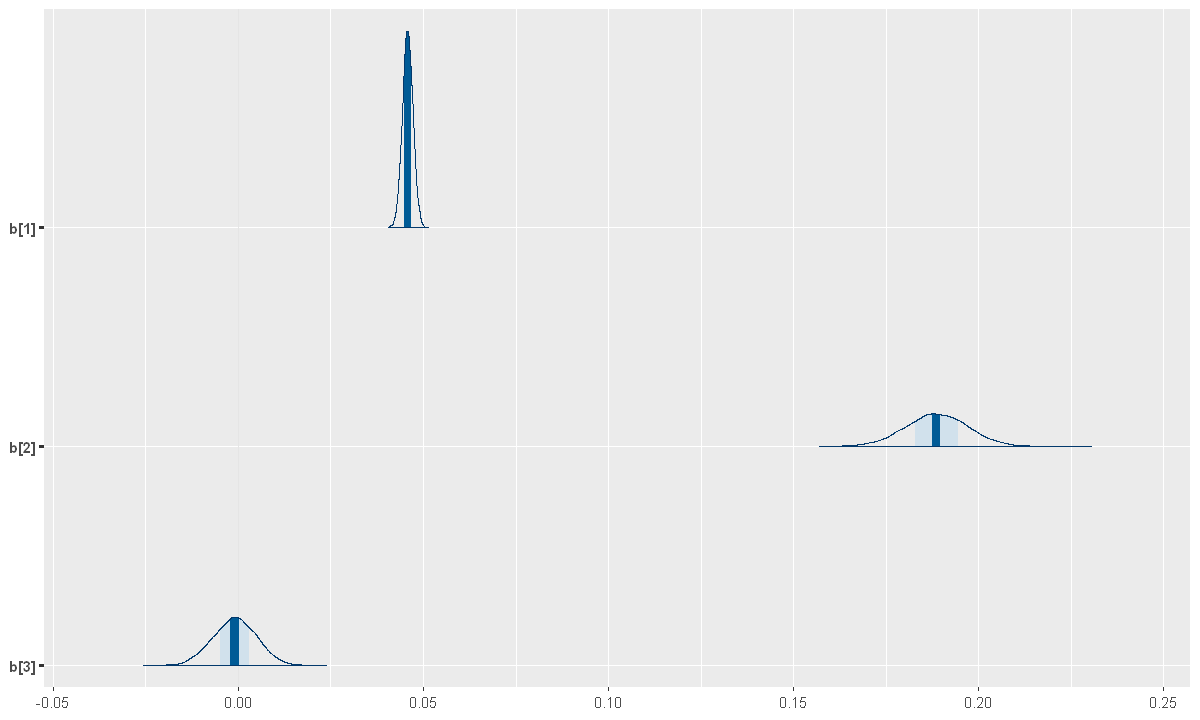

In [68]:
options(repr.plot.width=10, repr.plot.height=6)
color_scheme_set("mix-blue-red")
mcmc_areas(Advertising.stan.m1, pars = vars(starts_with("b")))

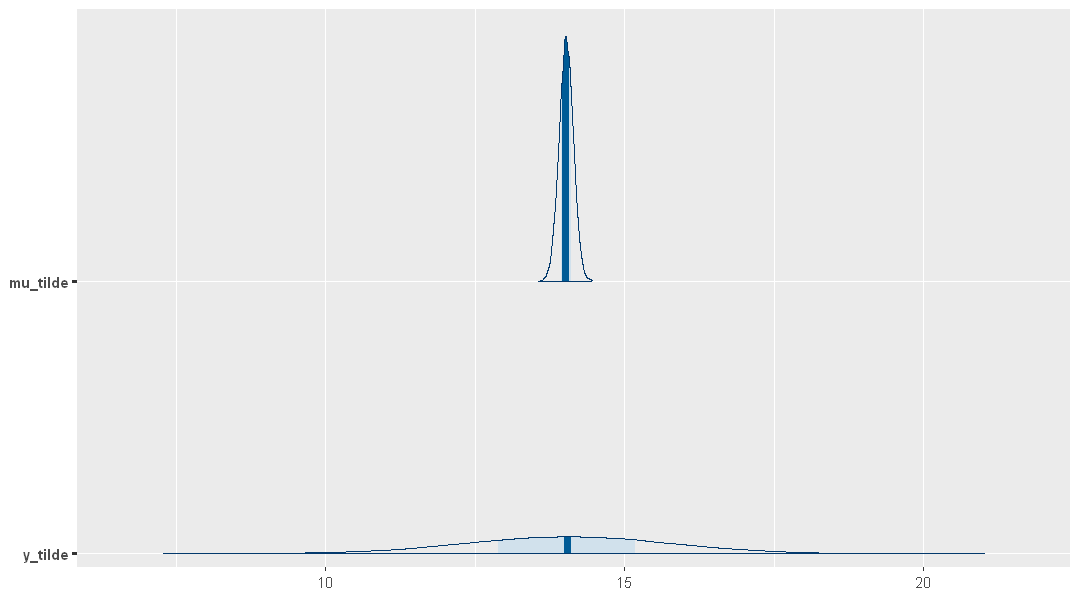

In [69]:
options(repr.plot.width=9, repr.plot.height=5)
color_scheme_set("blue")
mcmc_areas(Advertising.stan.m1, pars = c("mu_tilde","y_tilde"))

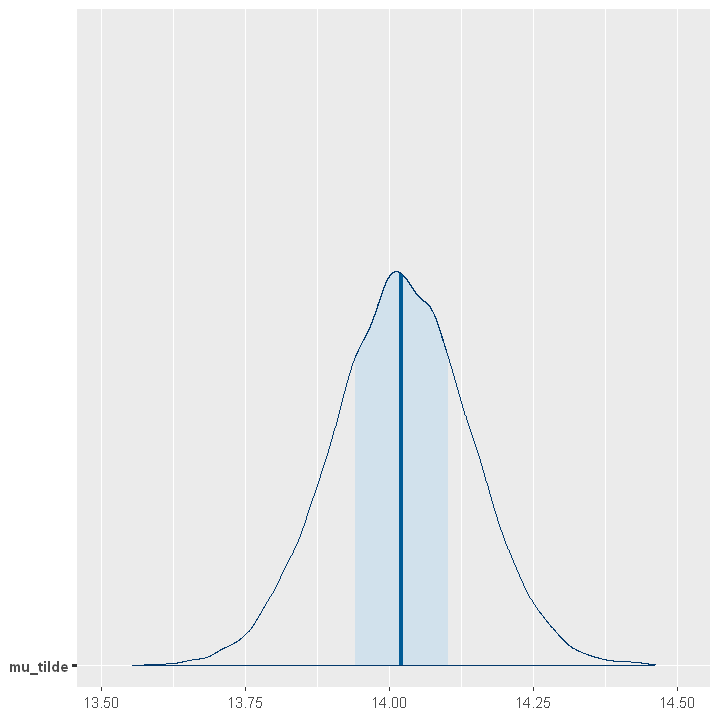

In [70]:
options(repr.plot.width=6, repr.plot.height=6)
color_scheme_set("blue")
mcmc_areas(Advertising.stan.m1, pars = c("mu_tilde"))

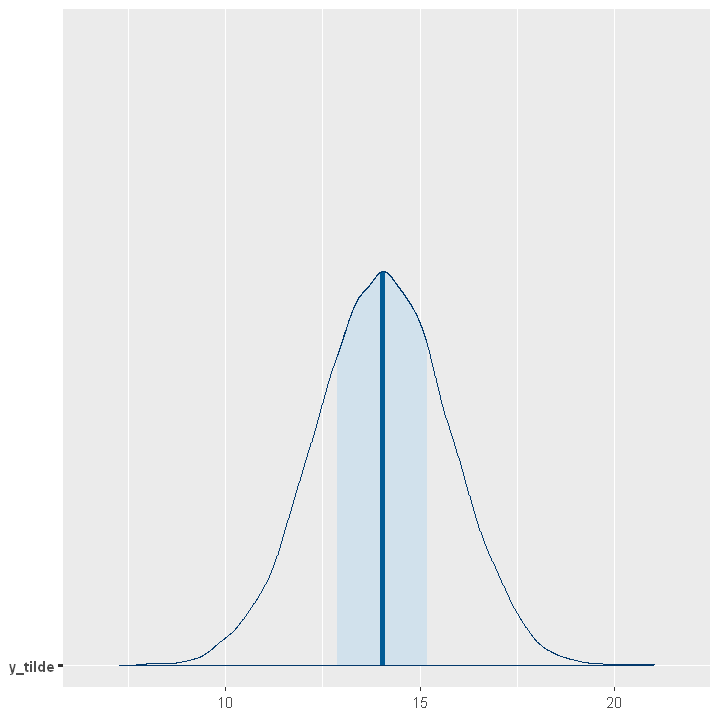

In [71]:
options(repr.plot.width=6, repr.plot.height=6)
color_scheme_set("blue")
mcmc_areas(Advertising.stan.m1, pars = c("y_tilde"))

Predicted `y_tilde` has two sources of uncertainty: that of the regression coefficients `a` and  `b` plus that of the generated `y`.

When both quantities are represented separately, this information is lost.

###  Posterior density plots

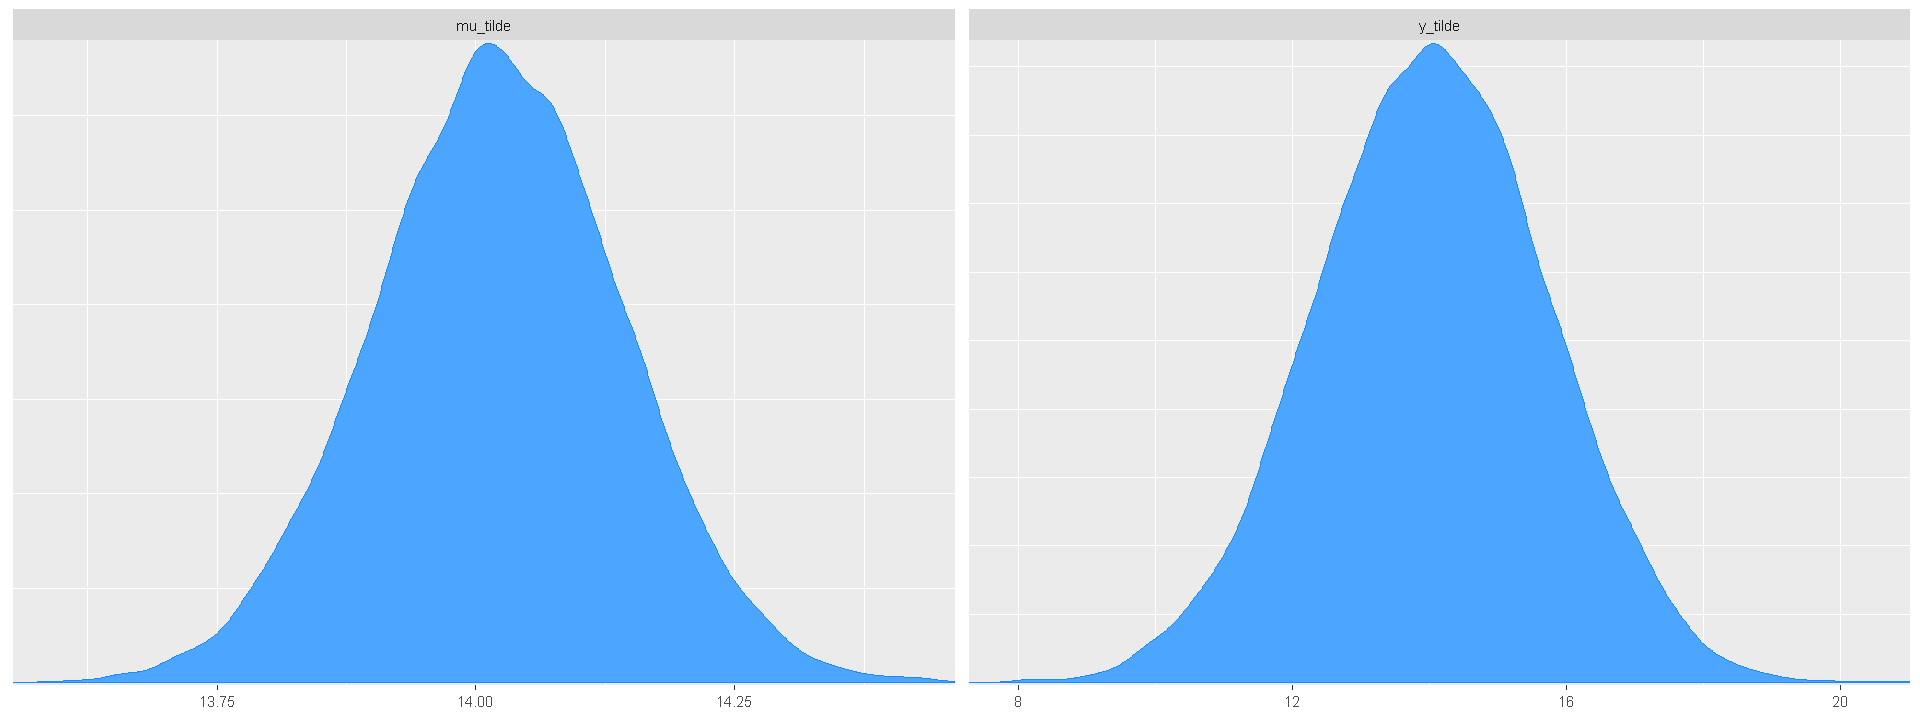

In [72]:
options(repr.plot.width=16, repr.plot.height=6)
color_scheme_set("brightblue")
mcmc_dens(Advertising.stan.m1, pars = c("mu_tilde","y_tilde"))